In [105]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [106]:
##helpers
def extract_hour(s):
    """Return hour (int) from strings like '22:20' or '01:10 22 Mar'."""
    if pd.isna(s):
        return np.nan
    m = re.search(r'(\d{1,2}):(\d{2})', str(s))
    return int(m.group(1)) if m else np.nan

def duration_to_minutes(x):
    """Convert duration string '2h 50m', '19h', '50m' to total minutes (int)."""
    if pd.isna(x): 
        return np.nan
    s = str(x)
    h = re.search(r'(\d+)\s*h', s)
    m = re.search(r'(\d+)\s*m', s)
    hours = int(h.group(1)) if h else 0
    mins = int(m.group(1)) if m else 0
    return hours * 60 + mins

def stops_to_num(x):
    """Convert 'non-stop'->0, '1 stop'->1, '2 stops'->2, etc."""
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()
    if "non" in s:
        return 0
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else np.nan

In [107]:
##Load
df=pd.read_excel('flightprice.xlsx')
print("Initial shape:", df.shape)
pd.set_option("display.max_columns", None)

Initial shape: (10683, 11)


In [108]:
##Basic cleaning
# Trim whitespace, convert obvious 'nan' strings to actual NaN
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()
df.replace({"nan": np.nan, "NaN": np.nan, "None": np.nan, "no info": "No info"}, inplace=True)

In [109]:
##Feature extraction
# Date -> Journey Day/Month/Year
df["Journey_dt"] = pd.to_datetime(df["Date_of_Journey"], dayfirst=True, errors="coerce")
df["Journey_Day"] = df["Journey_dt"].dt.day
df["Journey_Month"] = df["Journey_dt"].dt.month
df["Journey_Year"] = df["Journey_dt"].dt.year


In [110]:
# Dep/Arrival hour
df["Dep_Hour"] = df["Dep_Time"].apply(extract_hour)
df["Arrival_Hour"] = df["Arrival_Time"].apply(extract_hour)

In [111]:
# Duration -> minutes
df["Duration_minutes"] = df["Duration"].apply(duration_to_minutes)

In [112]:
# Total_Stops -> numeric
df["stops_num"] = df["Total_Stops"].apply(stops_to_num)

In [113]:
# Report missing counts
print("\nMissing counts (selected cols):")
print(df[["Journey_dt", "Duration_minutes", "stops_num", "Dep_Hour", "Arrival_Hour"]].isna().sum())


Missing counts (selected cols):
Journey_dt          0
Duration_minutes    0
stops_num           1
Dep_Hour            0
Arrival_Hour        0
dtype: int64


In [114]:
 ###Drop rows missing duration or stops (rare in your dataset)
df = df.dropna(subset=["Duration_minutes", "stops_num"]).reset_index(drop=True)
print("After dropping rows missing Duration/stops:", df.shape)

After dropping rows missing Duration/stops: (10682, 19)


In [115]:
###Price winsorize (IQR cap) and log target
price = df["Price"].astype(float)
Q1 = price.quantile(0.25)
Q3 = price.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nPrice stats before capping: min={price.min():.0f}, max={price.max():.0f}, mean={price.mean():.2f}")
print(f"IQR bounds -> lower: {lower_bound:.2f}, upper: {upper_bound:.2f}")


Price stats before capping: min=1759, max=79512, mean=9087.21
IQR bounds -> lower: -5367.00, upper: 23017.00


In [116]:
df["Price_capped"] = df["Price"].clip(lower=lower_bound, upper=upper_bound)
df["log_Price"] = np.log1p(df["Price_capped"])   # chosen modeling target
print(f"Price stats after capping: min={df['Price_capped'].min():.0f}, max={df['Price_capped'].max():.0f}, mean={df['Price_capped'].mean():.2f}")

Price stats after capping: min=1759, max=23017, mean=9022.04


Text(0, 0.5, 'Count')

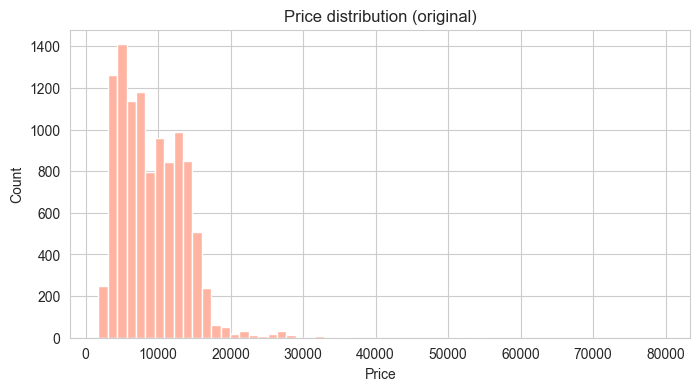

In [117]:
##Quick EDA plots
plt.figure(figsize=(8,4))
plt.hist(price.dropna(), bins=60,color="#FFB4A2")
plt.title("Price distribution (original)")
plt.xlabel("Price")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

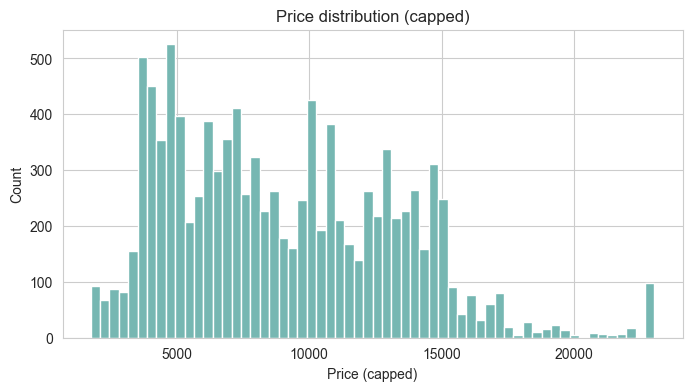

In [118]:
plt.figure(figsize=(8,4))
plt.hist(df["Price_capped"].dropna(), bins=60,color="#76B7B2")
plt.title("Price distribution (capped)")
plt.xlabel("Price (capped)")
plt.ylabel("Count")


Text(0, 0.5, 'Count')

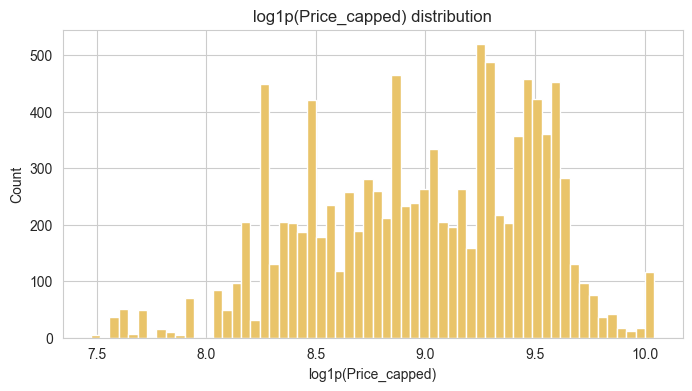

In [119]:
plt.figure(figsize=(8,4))
plt.hist(df["log_Price"].dropna(), bins=60,color="#E9C46A")
plt.title("log1p(Price_capped) distribution")
plt.xlabel("log1p(Price_capped)")
plt.ylabel("Count")


/var/folders/61/323z6ktx10b5m3jr3rk9s9y40000gn/T/ipykernel_69394/3736077850.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="stops_num", y="Price_capped", data=df, palette="Set2")


Text(0, 0.5, 'Price_capped')

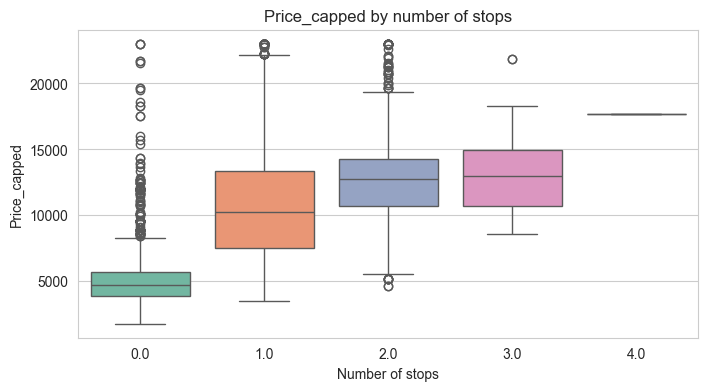

In [127]:
# Boxplot: Price_capped by stops_num
plt.figure(figsize=(8,4))
# prepare groups for boxplot with sorted stops
groups = [df[df["stops_num"] == k]["Price_capped"].values for k in sorted(df["stops_num"].dropna().unique())]
labels = [str(int(k)) for k in sorted(df["stops_num"].dropna().unique())]
# plt.boxplot(groups, labels=labels)
sns.boxplot(x="stops_num", y="Price_capped", data=df, palette="Set2")
plt.title("Price_capped by number of stops")
plt.xlabel("Number of stops")
plt.ylabel("Price_capped")

Text(0, 0.5, 'Price_capped')

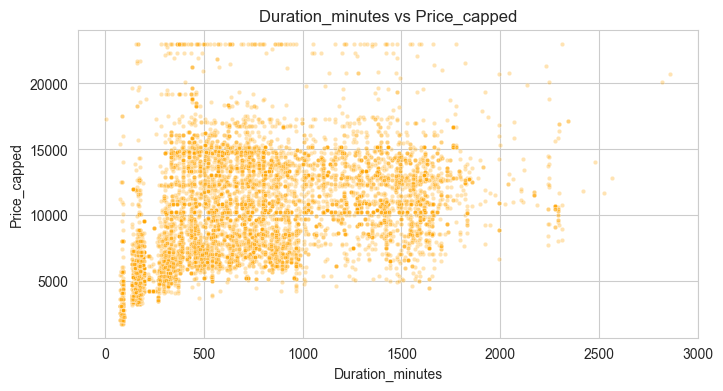

In [ ]:
# Scatter: Duration vs Price_capped
plt.figure(figsize=(8,4))
plt.scatter(df["Duration_minutes"], df["Price_capped"], alpha=0.3, s=10, edgecolors='w', linewidth=0.5, color='orange')
plt.title("Duration_minutes vs Price_capped")
plt.xlabel("Duration_minutes")
plt.ylabel("Price_capped")

Text(0, 0.5, 'Count')

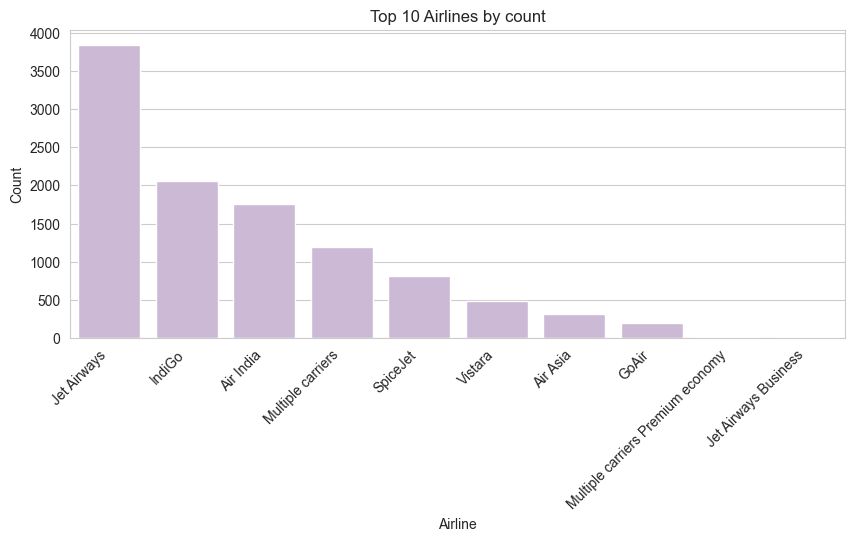

In [ ]:
# Top airlines bar chart
top_airlines = df["Airline"].value_counts().head(10)
plt.figure(figsize=(10,4))
sns.barplot(x=top_airlines.index, y=top_airlines.values,color="#CDB4DB")
plt.title("Top 10 Airlines by count")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")

Text(0.5, 1.0, 'Numeric feature correlations')

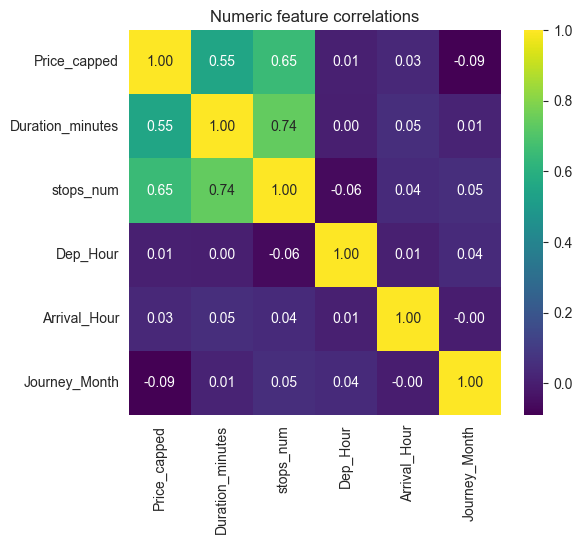

In [ ]:
# Correlation heatmap of numeric columns
num_cols = ["Price_capped", "Duration_minutes", "stops_num", "Dep_Hour", "Arrival_Hour", "Journey_Month"]
plt.figure(figsize=(6,5))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Numeric feature correlations")

In [ ]:
# Select features to keep
features = [
    "Duration_minutes", "stops_num", "Dep_Hour", "Arrival_Hour",
    "Journey_Day", "Journey_Month",
    "Airline", "Source", "Destination",
    "Price", "Price_capped", "log_Price"
]
processed = df[features].copy()

In [ ]:
# One-hot encode low-cardinality categoricals (drop_first=True to avoid dummy trap)
ohe_cols = ["Airline", "Source", "Destination"]
processed_ohe = pd.get_dummies(processed, columns=ohe_cols, drop_first=True)
print("Processed shape:", processed_ohe.shape)

Processed shape: (10682, 29)


In [ ]:
##Quick value counts and stats
print("\nTop 10 airlines:")
print(df["Airline"].value_counts().head(10))
print("\nAdditional_Info top values:")
print(df["Additional_Info"].value_counts().head(10))



Top 10 airlines:
Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Name: count, dtype: int64

Additional_Info top values:
Additional_Info
No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64


In [130]:
##Showing a sample of processed data
# print("\nSample of processed data (first 5 rows):")
processed_ohe.head(5)  # transposed preview

,Duration_minutes,stops_num,Dep_Hour,Arrival_Hour,Journey_Day,Journey_Month,Price,Price_capped,log_Price,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,170,0.0,22,1,24,3,3897,3897,8.268219,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,445,2.0,5,13,1,5,7662,7662,8.944159,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,1140,2.0,9,4,9,6,13882,13882,9.538420,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
3,325,1.0,18,23,12,5,6218,6218,8.735364,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,285,1.0,16,21,1,3,13302,13302,9.495745,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [132]:
print(processed_ohe.shape)
processed_ohe.to_csv("processed_flight_data.csv", index=False)

(10682, 29)
